<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 2 ISPR 2023 - Assignment 2 - Salvatore Correnti (matr. 584136)
In this assignment we will implement and test a simple image understanding application based on the `Latent Dirichlet Allocation` model applied to images.

## Initial Imports
As in the first assignment, before any coding we reserve a couple of cells for changing working directory and for all needed imports.

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023"

/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
import os
from PIL import Image
from typing import *
import math
import matplotlib.pyplot as plt
from time import perf_counter
from gensim.models.ldamodel import LdaModel as LDA

## Latent Dirichlet Allocation for Image Understanding
`Latent Dirichlet Allocation (LDA)` is a generative model that is used for discovering categories (called `topics`) from a set of `documents` composed of `words` and to classify those documents mixtures of those topics with one `"main" topic`.

In Latent Dirichlet Allocation with $M$ documents made up of $N_1, ..., N_M$ words, we model the distribution of document and word topics as following:
* $\alpha$ and $\eta$ are hyperparameters that define prior `Dirichlet` distributions respectively of the topics per document and of the words per topic;
* $\theta$ is a set of random variables representing the topic distributions for each of the documents, which are modelled as $Dirichlet(\alpha)$;
* $\beta$ is a set of random variables representing the (prior) topic distributions for each topic, modelled as $Dirichlet(\eta)$;
* $Z$ is a set of random variables representing each word for each topic;
* $W$ is a set of random variables representing the words.

LDA models this as a graph of the form: $\alpha \rightarrow \theta \rightarrow Z \rightarrow W \leftarrow \beta \leftarrow \eta$

The terms `documents`, `words` and `topics` come from the fact that this model has been used mainly in the field of `Natural Language Processing` for document classification and tagging, using text corpora as training data, since this model is well suited for dealing with `atomic` units that have a semantic and appear in multiple documents.

### Bag of Visual Words Model
Traditional applications of `LDA` in Natural Language Processing operates on `Bag of Words` models for the documents. Given a document $\mathcal{D_i} = [w_1, ..., w_{N_i}]$ with words from a vocabulary $\mathcal{V} = \{v_1, ..., v_N\}$ as a sequence of words, if $\{v_{i_1}, ..., v_{i_{m_i}}\}$ is the corresponding *set* of words, we define $BOW(\mathcal{D_i}) := \{(i_1, occ_1), ..., (i_{m_i}, occ_{N_i})\}$ meaning with this the array that has $occ_j$ at positions $i_j\:\forall\:j$, and $0$ in all others, where $occ_j$ is the number of occurrences of word $v_{i_j}$ in $\mathcal{D}$.

For Computer Vision, we can define a vocabulary, called also `codebook`, from a training set as the following:

1. we extract features from all images in the training images using a feature detector and SIFT descriptor;
2. we then fix a number $N$ of "words" in the vocabulary and we perform *K-Means* on the *whole* set of descriptors for all images;
3. we take the $N$ *centroids* found by K-Means as *words*.

Given an image in test dataset, we transform it in a Bag of Visual Words by assigning each feature its nearest centroid.

#### 0.    Utility Functions
Before proceeding in the implementation of `BOVW` model, we define some utilities for operating with images.

In [ ]:
def pil_load_image(dir_path: str, file_name: str, to_grayscale=False) -> Image.Image:
  pil_image = Image.open(os.path.join(dir_path, file_name))
  return pil_image.convert('L') if to_grayscale else pil_image

def cv2_load_image(dir_path: str, file_name: str, to_grayscale=False) -> np.ndarray:
  cv2_image = cv2.imread(os.path.join(dir_path, file_name))
  if (len(cv2_image.shape) > 1) and to_grayscale:
    return cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
  else:
    return cv2_image

In [ ]:
def cv2_to_pil(img_array: np.ndarray):
  mode = cv2.COLOR_BGR2RGB if len(img_array.shape) == 3 else None
  if mode is not None:
    pil_img_array = cv2.cvtColor(img_array, mode)
  else:
    pil_img_array = img_array
  pil_img = Image.fromarray(pil_img_array)
  return pil_img, pil_img_array

def pil_to_cv2(img: Union[Image.Image, np.ndarray]):
  img_array = np.asarray(img) if isinstance(img, Image.Image) else img
  mode = cv2.COLOR_RGB2BGR if len(img_array.shape) == 3 else None
  if len(img_array.shape) == 3: #mode is not None:
    print('nia')
    cv2_img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
  else:
    cv2_img_array = img_array
  return cv2_img_array

Finally, for plotting results on multiple rows/columns:

In [ ]:
def plot_results(
    images: Union[Image.Image, list[Image.Image]],
    show=True, figsize_scale_factor=1,
    images_per_row=None, images_per_column=None,
  ):
  if isinstance(images, Image.Image):
    images = [images]
  if (images_per_row is None) or (images_per_column is None):
    images_per_row, images_per_column = len(images), 1
  elif (images_per_row * images_per_column != len(images)):
    raise ValueError(
      f"Mismatch between (images_per_row = {images_per_row}, " \
      f"images_per_column = {images_per_column}) and len(images): " \
      f"{images_per_row * images_per_column} vs {len(images)}"
    )
  n = len(images)
  # (6.4, 4.8) are the default values for figsize in matplotlib
  figsize = (figsize_scale_factor * 6.4, figsize_scale_factor * 4.8)
  fig, ax = plt.subplots(images_per_column, images_per_row, figsize=figsize)
  if n == 1:
    ax = np.array([ax]).reshape((1, 1))  # Uniforming with the case of n > 1
  if len(ax.shape) == 1:
    ax = np.reshape(ax, (1, len(ax)))
  for i in range(images_per_column):
    for j in range(images_per_row):
      ax[i, j].imshow(images[i * images_per_row + j], interpolation='nearest', cmap='gray')
      ax[i, j].plot()
  if show:
    plt.show()

In [ ]:
def count_occurrencies(data: np.ndarray, end=None, start=0, repr_type='sparse'):
  end = end if end is not None else len(data)
  if repr_type == 'dense':
    results = np.zeros(end, dtype=np.intc)
    for i in range(start, end):
      results[i] = len(data[data == i])
  elif repr_type == 'sparse':
    results = []
    for i in range(start, end):
      results.append(
          (start + i, len(data[data == i]))
      )
  else:
    raise ValueError(f"Unknown representation type '{repr_type}'")
  return results

In [ ]:
def draw_samples(
    prob_dists: np.ndarray, samples_per_dist: Union[int, list[int]]=1, seed=None
):
  # Handle cases in which samples_per_dist is a number or a list
  N = len(prob_dists)
  max_samples_per_dist = samples_per_dist \
  if isinstance(samples_per_dist, int) else max(samples_per_dist)
  samples_per_dist = N * [samples_per_dist] \
  if isinstance(samples_per_dist, int) else samples_per_dist

  # Now draw samples
  rng = np.random.default_rng(seed)
  samples = np.full((N, max_samples_per_dist), -1, dtype=np.intc)
  num_items = prob_dists.shape[1]
  for i in range(N):
    samples[i] = rng.choice(num_items, size=max_samples_per_dist, p=prob_dists[i])
    samples[i][samples_per_dist[i]:] = -1
  return samples

#### 1. SIFT Feature Extraction
We can use any of already `cv2` implemented feature detectors for detecting keypoints and the `SIFT` feature extractor available in `OpenCV` to compute their *descriptors*. By default, we use `SIFT` also for feature detection.

In [ ]:
def apply_sift(img_array: np.ndarray, detector=None):
  sift = cv2.SIFT_create()
  if detector is None or detector == 'sift':
    keypoints, descriptors = sift.detectAndCompute(img_array, None)
  elif detector == 'mser':
    mser = cv2.MSER_create()
    keypoints = mser.detect(img_array)
    keypoints, descriptors = sift.compute(img_array, keypoints)
  else:
    keypoints = detector.detect(img_array)
    keypoints, descriptors = sift.compute(img_array, keypoints)
  for keypoint in keypoints:
    keypoint.angle = -1
  return keypoints, descriptors

We add a bit of complexity for handling colors when dealing with arbitrary numbers of keypoint categories.

In [ ]:
DEFAULT_COLORS = [
    (0, 0, 0), (0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255),                # black, red, green, blue, cyan
    (255, 165, 0), (255, 192, 203), (128, 0, 128), (165, 42, 42), (64, 224, 208),   # orange, pink, purple, brown, turquoise
    (128, 128, 128), (255, 0, 255), (230, 230, 230), (128, 0, 0), (0, 0, 128),      # gray, magenta, lavender, maroon, navy
    (0, 128, 128), (128, 128, 0), (255, 218, 185), (210, 180, 140), (245, 245, 220) # teal, olive, peach, tan, beige
]

_COLOR_CONST = 16

def _generate_color(b_idx, g_idx, r_idx):
  return (b_idx * (256//_COLOR_CONST), g_idx * (256//_COLOR_CONST), r_idx * (256//_COLOR_CONST))

def _generate_colors(max_class_id):
  if (max_class_id > (256//_COLOR_CONST)**3):
    raise OverflowError(f"Cannot generate colors for a value {max_class_id} > {_COLOR_CONST**3}")
  red_idx = max_class_id % _COLOR_CONST
  green_idx = (max_class_id // _COLOR_CONST) % _COLOR_CONST
  blue_idx = (max_class_id // _COLOR_CONST) // _COLOR_CONST
  colors = []
  for i in range(blue_idx+1):
    for j in range(_COLOR_CONST):
      for k in range(_COLOR_CONST):
        j_valid = (i < blue_idx) or (j <= green_idx)
        k_valid = (i < blue_idx) or (j < green_idx) or (k < red_idx)
        if not (j_valid and k_valid):
          continue
        colors.append(_generate_color(i, j, k))
  return colors

def draw_keypoints(img_array: np.ndarray, keypoints, class_ids=False, max_class_id=None, colors=None, **kwargs):
  if class_ids:
    if (max_class_id is None) or not (isinstance(max_class_id, int)) or (max_class_id < 0):
      raise ValueError(f"If class_ids=True, max_class_id must be an integer >= 0 (found '{max_class_id}')")
    if colors is None:
      use_defaults = (max_class_id <= len(DEFAULT_COLORS))
      colors = DEFAULT_COLORS if use_defaults else _generate_colors(max_class_id)
      if not use_defaults:
        np.random.shuffle(colors)
    elif len(colors) < max_class_id:
      colors = _generate_colors(max_class_id)
      np.random.shuffle(colors)
    for i in range(max_class_id):
      id_kp = [keypoint for keypoint in keypoints if keypoint.class_id == i]
      if len(id_kp) > 0:
        img_array = cv2.drawKeypoints(img_array, id_kp, None, colors[i], **kwargs)
    return img_array, colors
  else:
    return cv2.drawKeypoints(img_array, keypoints, None, **kwargs), colors

And now an example:

(125, 128)


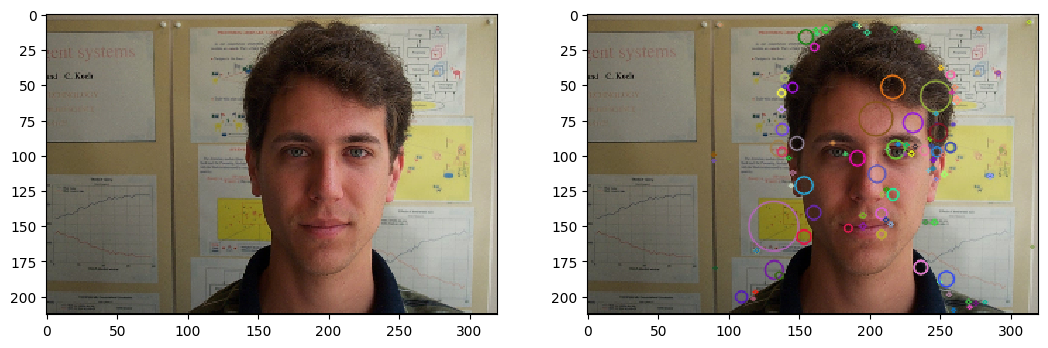

In [ ]:
dir_path = 'MSRC_ObjCategImageDatabase_v1'
file_name = '6_4_s.bmp'
# Load images
pil_rgb_image = pil_load_image(dir_path, file_name)
cv2_bgr_image = cv2_load_image(dir_path, file_name)
cv2_gray_image = cv2.cvtColor(cv2_bgr_image, cv2.COLOR_BGR2GRAY)
# Extract features
keypoints, descriptors = apply_sift(cv2_gray_image)
print(descriptors.shape)
# Draw keypoints and convert to PIL
cv2_bgr_image_keypoints, _ = draw_keypoints(cv2_bgr_image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
pil_rgb_image_keypoints, _ = cv2_to_pil(cv2_bgr_image_keypoints)
# Show original and keypoints images
plot_results(
    [pil_rgb_image, pil_rgb_image_keypoints], figsize_scale_factor=2,
)

#### 2. Dataset
We will use the same dataset as in `Midterm 1`:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

In this case we will use the whole dataset for training and testing. Since we want to have *reproducible* experiments, we will implement a sampling procedure from the whole dataset s.t. we can pass a seed to *always* get the *same* dataset each time we run this notebook.

In [ ]:
def train_test_split(
    dir_path: str, test_images_per_category: int = 1,
    random_state: Union[int, None] = None,
):
  filenames = os.listdir(dir_path)
  filenames = [filename for filename in filenames if ('GT' not in filename) and ('bmp' in filename)]
  filenames_by_category = {str(i): [] for i in range(1, 9)}
  for filename in filenames:
    filenames_by_category[filename[0]].append(filename)

  for k, v in filenames_by_category.items():
    filenames_by_category[k] = sorted(v, key=lambda x: int(x.split('_')[1]))

  rng = np.random.default_rng(random_state)

  train_images = []
  test_images = []

  for i in range(test_images_per_category):
    indexes = rng.integers(30-i, size=8)
    for j in range(1, 9):
      v = filenames_by_category[str(j)]
      test_images.append(v.pop(indexes[j-1]))

  for i in range(1, 9):
    train_images += filenames_by_category[str(i)]
  
  return train_images, test_images

#### 3. Building the codebook
The next step is to build a `codebook` from the SIFT descriptors extracted from training images. A `codebook` is a vocabulary that indexes visual words such that each SIFT descriptor can be assigned a word in the codebook itself. In other terms, we will *cluster* the SIFT descriptors extracted from the training images into $k$ clusters and our codebook will contain a representative word for each of the $k$ clusters.

In our case, we will use `KMeans` as clustering algorithm and we will save each of the $k$ `centroids` found by KMeans as representative words.

In [ ]:
class Codebook:
  def __init__(
      self, dir_path, train_images_filenames: list[str],
      n_clusters=10, max_iter=1000,
  ):
    cv2_gray_images = [
      cv2_load_image(dir_path, train_image_filename, to_grayscale=True)
      for train_image_filename in train_images_filenames
    ]
    # SIFT descriptors
    sift_outputs = [apply_sift(img_array) for img_array in cv2_gray_images]
    # Descriptors for all images
    image_descriptors = [sift_output[1] for sift_output in sift_outputs]
    # Keypoints for all images
    self.image_keypoints = [sift_output[0] for sift_output in sift_outputs]
    # |descriptors| for each image
    self.image_descriptors_lengths = [len(image_descriptor) for image_descriptor in image_descriptors]
    self.num_images = len(image_descriptors)
    self.image_descriptors = np.row_stack(image_descriptors)
    self.n_clusters = n_clusters
    kmeans = KMeans(n_clusters, max_iter=max_iter, n_init='auto').fit(self.image_descriptors)
    self._kmeans = kmeans
    # Rewrite the labels in "proper" way
    self._labels = self._adapt_labels(self._kmeans.labels_, self.image_descriptors_lengths)
    # Set class id for all keypoints
    self._set_keypoints_labels(self.image_keypoints, self.labels)
  
  @staticmethod
  def _adapt_labels(labels: list[int], lengths: list[int]) -> list[np.ndarray]:
    result = []
    num_images = len(lengths)
    for i in range(num_images):
      start_index = sum(lengths[:i])
      result.append(
        np.array([labels[start_index+j] for j in range(lengths[i])], dtype=np.intc)
      )
    return result
  
  @staticmethod
  def _set_keypoints_labels(keypoints, labels):
    for keypoints_list, labels_list in zip(keypoints, labels):
      for keypoint, label in zip(keypoints_list, labels_list):
        keypoint.class_id = label
  
  @property
  def labels(self):
    return self._labels
  
  @property
  def cluster_centers(self):
    return self._kmeans.cluster_centers_
  
  def get_cluster_centers(self, values: np.ndarray):
    return self.cluster_centers[self.get_cluster_indexes(values)]
  
  def get_cluster_indexes(self, values: np.ndarray):
    return [self._kmeans.predict(value) for value in values]

  # Return the Bag Of Visual Words representation for training images
  def get_training_bovw_representation(self) -> list[list[tuple[int, int]]]:
    results = []
    for i in range(self.num_images):
      results.append(count_occurrencies(self.labels[i], self.n_clusters))
    return results
  
  def get_test_bovw_representation(self, cv2_gray_images_arrays: np.ndarray):
    num_images = len(cv2_gray_images_arrays)
    sift_outputs = [
        apply_sift(cv2_gray_images_array) 
        for cv2_gray_images_array in cv2_gray_images_arrays
    ]
    keypoints = [sift_output[0] for sift_output in sift_outputs]
    descriptors = [sift_output[1] for sift_output in sift_outputs]
    indexes = self.get_cluster_indexes(descriptors)
    results = []
    for i in range(num_images):
      results.append(count_occurrencies(indexes[i], self.n_clusters))
    # Now set cluster values for all keypoints
    self._set_keypoints_labels(keypoints, indexes)
    return indexes, results, keypoints
  
  @staticmethod
  def to_dense(sparse_list: list[tuple[int, Any]]):
    return [val for idx, val in sparse_list]

In [ ]:
crt = perf_counter()
dir_path = 'MSRC_ObjCategImageDatabase_v1'
N_CLUSTERS = 500
train_images_filenames, test_images_filenames = train_test_split(
    dir_path, random_state=0,
)
codebook = Codebook(dir_path, train_images_filenames, N_CLUSTERS, 10_000)
crt = perf_counter() - crt
print(f"Elapsed time: {crt:.4f} seconds")

Elapsed time: 92.5417 seconds


We can now calculate a histogram-like representation for each of the categories we have detected with `KMeans` for each training image, visualize raw values and plot histograms for some images.

In [ ]:
def plot_bovw_images(
    bovw_repr: list[list[tuple[int, int]]], labels: list[list[int]],
    dir_path: str, images_filenames: list[str], keypoints, n_classes: int,
    nrows: int, figsize=(6.4, 4.8), show=True, verbose=True,
):
  fig, ax = plt.subplots(nrows, 2, figsize=figsize)
  if nrows == 1:
    ax = ax.reshape((1, 2))
  for i in range(len(bovw_repr)):
    if verbose:
      print(f"BOVW representation values: {bovw_repr[i]}")
    pil_image = pil_load_image(dir_path, images_filenames[i])
    cv2_bgr_image = cv2_load_image(dir_path, images_filenames[i])
    cv2_bgr_image, colors = draw_keypoints(
        cv2_bgr_image, keypoints[i], True,
        n_classes, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    pil_kp_image, _ = cv2_to_pil(cv2_bgr_image)
    ax[i, 0].imshow(pil_kp_image, interpolation='nearest', cmap='gray')
    ax[i, 1].hist(labels[i], np.arange(0, n_classes+1, 1), rwidth=1.0)
  if show:
    plt.show()

BOVW representation values: [(0, 0), (1, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 0), (9, 1), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 2), (17, 0), (18, 1), (19, 1), (20, 0), (21, 0), (22, 0), (23, 1), (24, 0), (25, 1), (26, 1), (27, 0), (28, 0), (29, 1), (30, 2), (31, 1), (32, 0), (33, 0), (34, 0), (35, 1), (36, 0), (37, 1), (38, 2), (39, 0), (40, 3), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 1), (47, 1), (48, 0), (49, 4), (50, 0), (51, 0), (52, 0), (53, 1), (54, 0), (55, 0), (56, 0), (57, 2), (58, 0), (59, 0), (60, 2), (61, 3), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 2), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 1), (76, 1), (77, 1), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 1), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 1), (94, 0), (95, 2), (96, 0), (97, 0), (98, 0), (99, 1), (100, 0), (101, 1), (102, 0), (103, 1), (104, 0), (105, 0), (106, 0), (107, 0), (

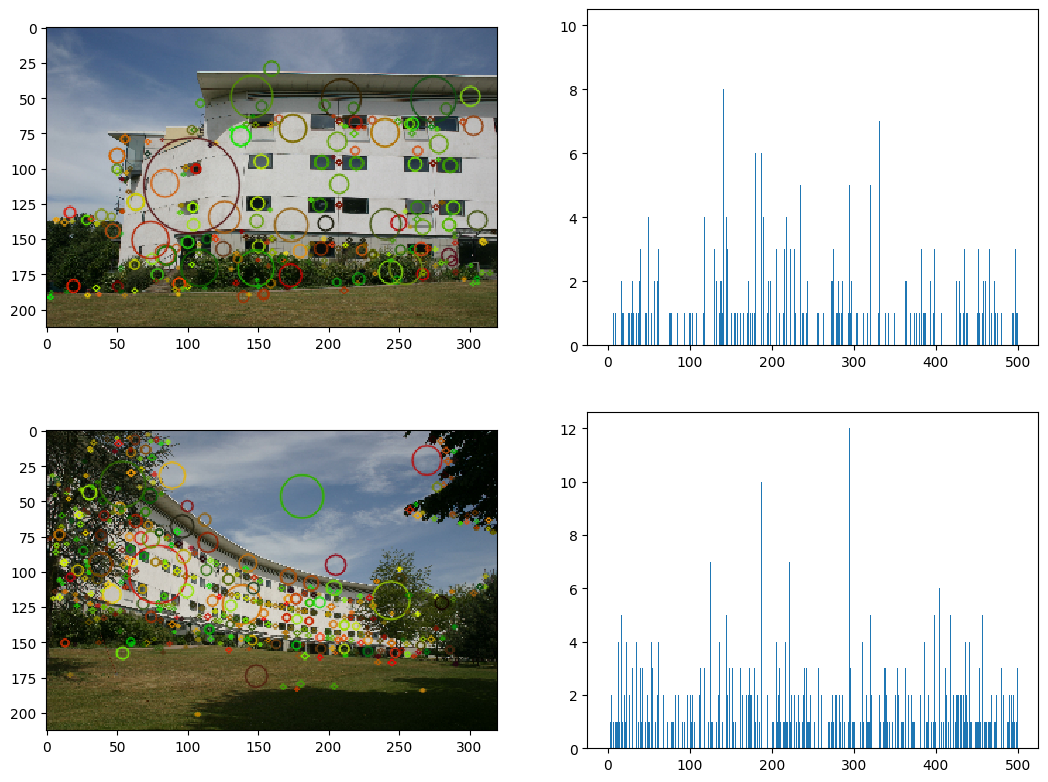

In [ ]:
N_IMAGES = 2
START = 80
train_bovw_representation = codebook.get_training_bovw_representation()
plot_bovw_images(
    train_bovw_representation[START:START+N_IMAGES],
    codebook.labels[START:START+N_IMAGES],
    dir_path, train_images_filenames[START:START+N_IMAGES],
    codebook.image_keypoints[START:START+N_IMAGES],
    n_classes=N_CLUSTERS, nrows=N_IMAGES, figsize=(12.8, 9.6), show=True,
)

#### 4. Test the KMeans for new images
We now need to test that the `codebook` is capable of giving this `BOVW` representation also for new images. In the `Codebook` class, we have implemented the `get_cluster_indexes()` method, which will convert a matrix of SIFT descriptors into the corresponding cluster centers indexes. Let's test it with a few test images:

BOVW representation values: [(0, 0), (1, 2), (2, 0), (3, 1), (4, 0), (5, 0), (6, 1), (7, 0), (8, 2), (9, 0), (10, 1), (11, 1), (12, 1), (13, 0), (14, 2), (15, 0), (16, 0), (17, 1), (18, 0), (19, 2), (20, 1), (21, 0), (22, 1), (23, 1), (24, 1), (25, 0), (26, 0), (27, 1), (28, 0), (29, 0), (30, 2), (31, 1), (32, 1), (33, 0), (34, 1), (35, 1), (36, 0), (37, 2), (38, 4), (39, 0), (40, 1), (41, 0), (42, 0), (43, 2), (44, 1), (45, 0), (46, 0), (47, 0), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 3), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 0), (62, 0), (63, 2), (64, 1), (65, 2), (66, 3), (67, 1), (68, 1), (69, 0), (70, 0), (71, 0), (72, 0), (73, 1), (74, 1), (75, 0), (76, 0), (77, 1), (78, 0), (79, 1), (80, 0), (81, 0), (82, 0), (83, 0), (84, 2), (85, 0), (86, 0), (87, 1), (88, 1), (89, 3), (90, 0), (91, 0), (92, 2), (93, 1), (94, 1), (95, 1), (96, 0), (97, 1), (98, 2), (99, 0), (100, 0), (101, 2), (102, 0), (103, 0), (104, 0), (105, 1), (106, 0), (107, 0), (

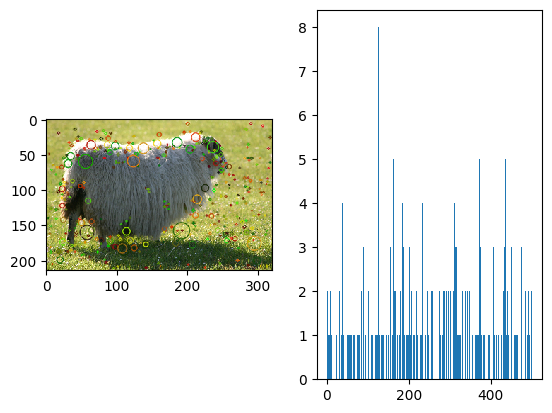

In [ ]:
cv2_test_image = cv2_load_image(dir_path, test_images_filenames[0], to_grayscale=True)
indexes, results, keypoints = codebook.get_test_bovw_representation([cv2_test_image])
plot_bovw_images(
    results, indexes, dir_path, test_images_filenames[0:1], keypoints,
    n_classes=codebook.n_clusters, nrows=1
)

### Using `LDA` for Image Understanding
Now that we have our `Codebook` and that we have tested the `KMeans`, we can introduce the `LDA`. We will use the `gensim` implementation.

#### 1. Building and training the `LDA`
At first, we define a convenient function for building and training our LDA over the documents that are stored in our `Codebook` object.

In [ ]:
def get_and_train_lda(
    codebook, n_topics=10, doc_topic_prior='auto',
    topic_word_prior='auto', iterations=100, **kwargs
):
  lda = LDA(
      codebook.get_training_bovw_representation(),
      num_topics=n_topics, alpha=doc_topic_prior, eta=topic_word_prior,
      per_word_topics=True, eval_every=1, passes=10, iterations=iterations, **kwargs
  )
  return lda

We will use an `LDA` with $20$ topics and $\alpha = 1, \eta = 1$ for simplicity.

In [ ]:
crt = perf_counter()
N_TOPICS = 20
ALPHA = 1
ETA = 1
lda = get_and_train_lda(codebook, N_TOPICS, ALPHA, ETA, iterations=1000, dtype=np.float64)
crt = perf_counter() - crt
print(f"Elapsed time: {crt:.4f} seconds")

Elapsed time: 43.1256 seconds


We can now calculate the empirical distribution of image topics for the training set to have an idea of how topics are distributed and what they may represent. Since both the categories $1$ and $5$ contains animals and cows in particular, we will plot *both* the entire distribution and the distribution excluding category $5$ to make sure that there are no category-related topics that may be "*doubled*" in their frequency being counted for two categories.

[ 1 10  7  1 11  1  1  8  0 25  7  0  5 34 10 25 30 22 27  7]
[ 1 10  7  1  9  1  1  4  0 15  7  0  5 34 10 23 25 16 27  7]


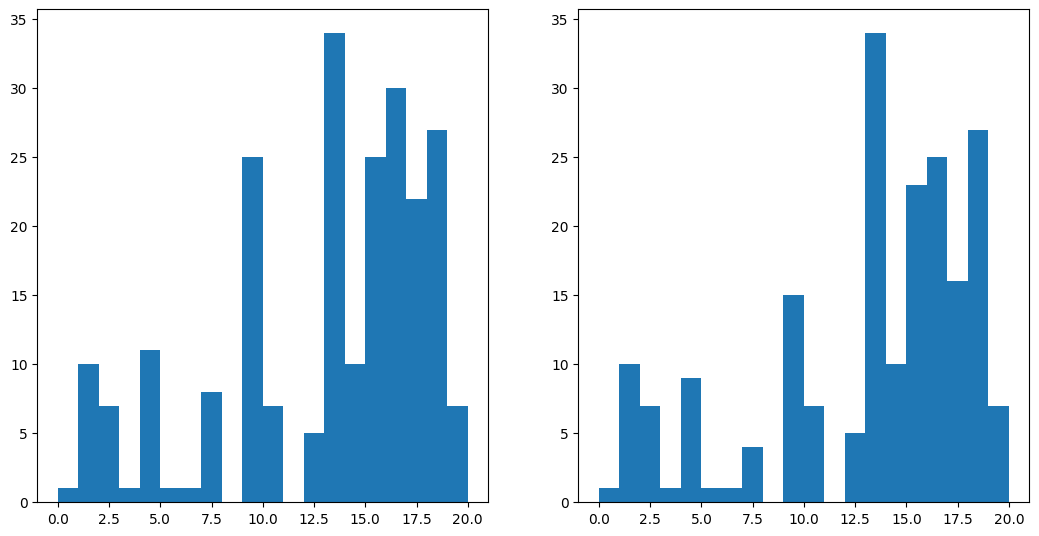

In [ ]:
EXCLUDE_CATEGORY = 4 # starting from 0 to 7
IMAGES_PER_CATEGORY = 29 # left out 1 example for testing
START, END = EXCLUDE_CATEGORY*IMAGES_PER_CATEGORY, (EXCLUDE_CATEGORY+1)*IMAGES_PER_CATEGORY

def select(l: list, start=START, end=END, exclude=True):
  if exclude:
    return l[0:start] + l[min(len(l), end):]
  else:
    return l[start:min(len(l), end)]

X = codebook.get_training_bovw_representation()
topic_probs = [Codebook.to_dense(lda.get_document_topics(X[i], minimum_probability=0.0)) for i in range(len(X))]
train_images_topics = draw_samples(np.array(topic_probs), seed=0)
# Now exclude second animals category
X_exclude = select(X)
topic_probs_exclude = select(topic_probs)
train_images_topics_exclude = np.array(select(list(train_images_topics)))

# Show numerically
print(count_occurrencies(train_images_topics.flatten(), 20, repr_type='dense'))
print(count_occurrencies(train_images_topics_exclude.flatten(), 20, repr_type='dense'))

# Show graphically
fig, ax = plt.subplots(1, 2, figsize=(12.8, 6.4))
ax[0].hist(train_images_topics, np.arange(N_TOPICS+1))
ax[1].hist(train_images_topics_exclude, np.arange(N_TOPICS+1))
plt.show()

As we can see we can divide topics in $3$ categories by the number of occurrencies in descending order:

1. $6$ "*dominant*" topics: $\{9, 13, 15, 16, 17, 18\}$;
2. $8$ intermediate ones: $\{1, 2, 4, 7, 10, 12, 14, 19\}$;
3. $6$ which occur less often or *never*: $\{0, 3, 5, 6, 8, 11\}$.

We can give a first interpretation as the following: the least occurring ones may correspond to **rare** features, the intermediate to quite common (or **category-related**) ones and the most frequent ones to **highly common** features that are likely to be *shared* between different categories.

We can now try to analyze the topic distribution for *each* of the categories, to confirm this first analysis:

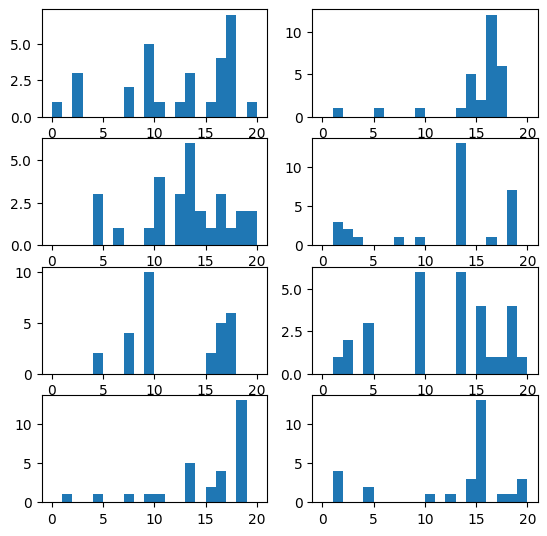

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(6.4, 6.4))
for i in range(8):
  category_images_topics = select(
      train_images_topics, start=i*IMAGES_PER_CATEGORY,
      end=(i+1)*IMAGES_PER_CATEGORY, exclude=False
  )
  ax[i // 2, i % 2].hist(category_images_topics, np.arange(N_TOPICS+1))
plt.show()

We observe a slightly different behaviour:

* topic $9$ is mostly concentrated in categories $1, 5$ (`animals`) and $6$ (`faces`) and almost *never* appears in the others, hence it may be related to facial or body features;
* topic $13$ is mostly frequent in categories $3$, $4$ and $6$ (`houses`, `planes` and `faces`);
* topic $15$ is dominant in categories $6$ and $8$ (`faces` and `bycicles`);
* topic $16$ is dominant in categories $2$ and $8$ (`trees` and `bycicles`);
* topic $17$ is dominant in $1,2, 5$ (`animals` and `trees`), hence it may be related to shapes in the grass or trees, that are common in all three categories;
* topic $18$ appears mostly in $4, 7$ (`planes` and `cars`), hence it may be related to the fact that these are vehicles.

All "rare" topics appear in at most $1$ category, while "intermediate" are distributed between different categories. We may so explain the meaning of the captured topics as following:
* common topics refer to "low-level" features, like geometrical shapes or textures, that may be present in different categories;
* intermediate topics describe some category-related features, even if they *do not* uniquely identify categories;
* rare topics describe rare, category-related features. Moreover, the fact that there are some topics that never appear may indicate that we may need less topics to capture the *real* meanings.

#### 2. Inference with `LDA`
We can now perform *inference* on new (test) images with our newly trained LDA. In `gensim`, the `get_document_topics()` method with `per_document_topics=True` returns as first argument an array representing the probability distribution $P(\theta|\textbf{w}, \alpha, \beta)$ and as second one a list of the most likely topics for each word, given $\textbf{w}, \alpha, \beta$. We can then use the first one to sample one topic per document and the second one e.g. for assigning to each word its most likely topic.

In [ ]:
num_test_images = len(test_images_filenames)
cv2_gray_images_arrays = [
    cv2_load_image(dir_path, test_img_filename, to_grayscale=True)
    for test_img_filename in test_images_filenames
]
test_indexes, test_results, test_keypoints = codebook.get_test_bovw_representation(cv2_gray_images_arrays)

test_topic_and_words_dists = [
    lda.get_document_topics(test_results[i], minimum_probability=0.0,
    per_word_topics=True)[0:2] for i in range(num_test_images)  # discard phi values (third result)
]

test_topic_image_prob_dists = np.array([
    Codebook.to_dense(test_topic_and_words_dists[i][0])
    for i in range(num_test_images)
])
# Draw samples for image topics
test_images_topics = draw_samples(test_topic_image_prob_dists, 1, seed=0)
# Now extract first word topic for each word for each image
test_word_topics_lists = [item[1] for item in test_topic_and_words_dists] # take only the most likely
test_word_topics = []
for i in range(len(test_word_topics_lists)):
  lists = test_word_topics_lists[i]
  #print(lists)
  test_word_topics.append([val[1][0] if len(val[1]) > 0 else -1 for val in lists])

print("Topics per image (words topics): ")
print(
    *[f"{filename} -> {topic} {word_topics}" for filename, topic, word_topics \
      in zip(test_images_filenames, test_images_topics, test_word_topics)],
      sep='\n'
)

Topics per image (words topics): 
1_26_s.bmp -> [16] [-1, 16, -1, 16, -1, -1, 16, -1, 18, -1, 16, 16, 16, -1, 16, -1, -1, 7, -1, 7, 16, -1, 16, 7, 16, -1, -1, 18, -1, -1, 18, 18, 16, -1, 16, 7, -1, 7, 16, -1, 16, -1, -1, 16, 16, -1, -1, -1, 16, 18, 16, 16, 16, 16, 16, 16, 16, 18, 16, 7, 7, -1, -1, 18, 7, 16, 16, 18, 16, -1, -1, -1, -1, 16, 16, -1, -1, 7, -1, 16, -1, -1, -1, -1, 7, -1, -1, 16, 16, 16, -1, -1, 16, 7, 16, 7, -1, 7, 16, -1, -1, 7, -1, -1, -1, 16, -1, -1, 16, -1, 16, 16, -1, -1, 16, -1, -1, 7, 16, 16, -1, 16, -1, 7, 16, 18, 16, -1, 7, -1, -1, 7, 16, 16, 7, 16, -1, 16, 7, -1, -1, -1, -1, -1, -1, 16, 18, -1, 16, -1, 16, -1, -1, -1, 18, 7, -1, -1, -1, -1, 16, 7, 7, -1, 16, -1, -1, 18, -1, -1, -1, 7, 16, 16, -1, 16, 7, 16, 16, 7, -1, 7, -1, 16, 16, -1, 7, -1, 7, 16, -1, -1, -1, 17, 16, 16, 18, 7, 7, 18, -1, 7, -1, 16, 7, 16, 16, 7, -1, -1, 7, 16, -1, 16, -1, 16, -1, -1, 16, -1, 16, 16, -1, -1, -1, -1, -1, 7, 7, 7, 16, -1, -1, 7, 16, -1, -1, -1, -1, 16, 16, 7, -1, 16, 16, 7, -1,

Now that we have extracted image and word (SIFT descriptors) topics, we need to map them to the corresponding keypoints to get a representation of what the model has extracted from data.

In [ ]:
def assign_topics_to_words(word_topics: list[list[int]], keypoints: list[list[cv2.KeyPoint]]):
  topic_keypoints, topic_labels = [], []
  for image_word_topics, image_keypoints in zip(word_topics, keypoints):
    current_keypoints = [
      cv2.KeyPoint(
          *keypoint.pt, size=keypoint.size, angle=-1, response=keypoint.response,
          octave=keypoint.octave, class_id=image_word_topics[keypoint.class_id]
      ) for keypoint in image_keypoints
    ]
    current_labels = [keypoint.class_id for keypoint in current_keypoints]
    topic_keypoints.append(current_keypoints)
    topic_labels.append(current_labels)
  return topic_keypoints, topic_labels

In [ ]:
def count_word_topics_occurrencies(word_topics: list[list[int]], word_occurrencies: list[list[int]], num_topics):
  results = []
  for image_word_topics, image_word_occurrencies in zip(word_topics, word_occurrencies):
    current = num_topics * [0]
    for word_topic, word_occurrencies in zip(image_word_topics, image_word_occurrencies):
      if word_topic > -1:
        current[word_topic] += word_occurrencies[1]
    results.append(current)
  return results

432 - Topic occurrencies: [0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 245, 3, 41, 0]
587 - Topic occurrencies: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 6, 0, 580, 0, 0, 0]
508 - Topic occurrencies: [0, 0, 0, 0, 422, 0, 0, 0, 0, 0, 1, 0, 51, 29, 0, 0, 5, 0, 0, 0]
294 - Topic occurrencies: [0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 3, 0, 0, 117, 0]
499 - Topic occurrencies: [0, 0, 0, 0, 0, 0, 0, 62, 0, 327, 1, 0, 2, 13, 0, 0, 29, 65, 0, 0]
564 - Topic occurrencies: [0, 14, 0, 0, 0, 0, 0, 31, 0, 37, 5, 0, 4, 0, 0, 153, 0, 267, 52, 1]
412 - Topic occurrencies: [0, 55, 0, 0, 0, 0, 0, 2, 0, 0, 9, 0, 0, 249, 0, 0, 23, 0, 74, 0]
685 - Topic occurrencies: [0, 98, 0, 0, 13, 0, 0, 0, 0, 0, 3, 0, 0, 217, 0, 352, 2, 0, 0, 0]


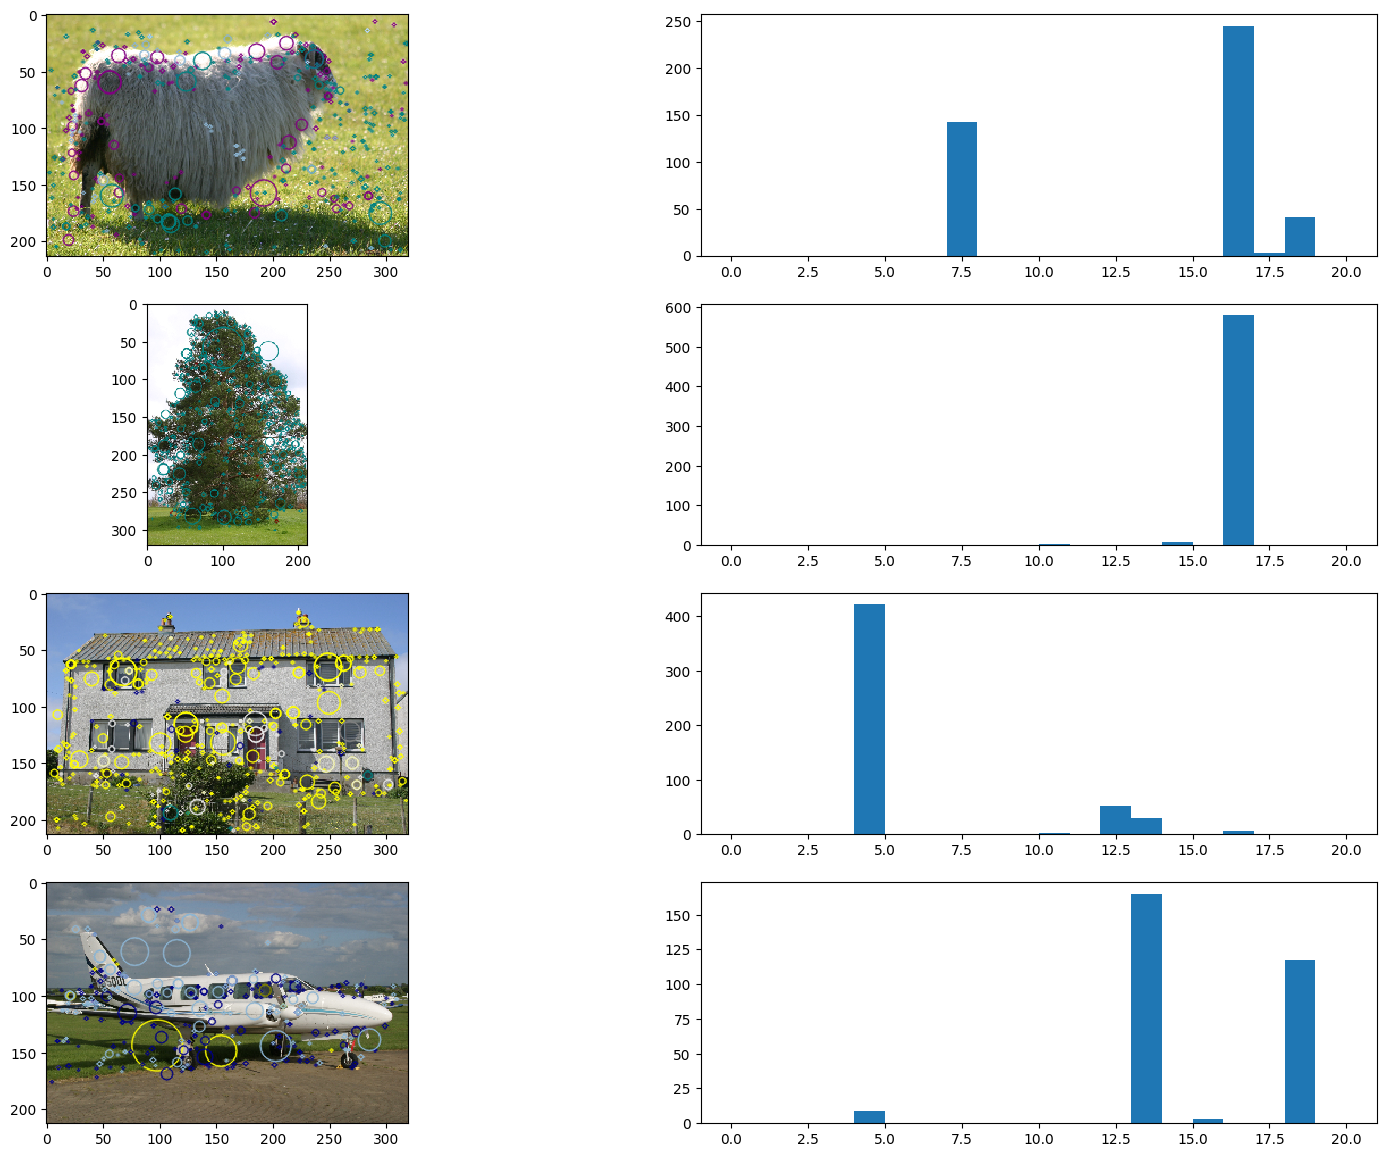

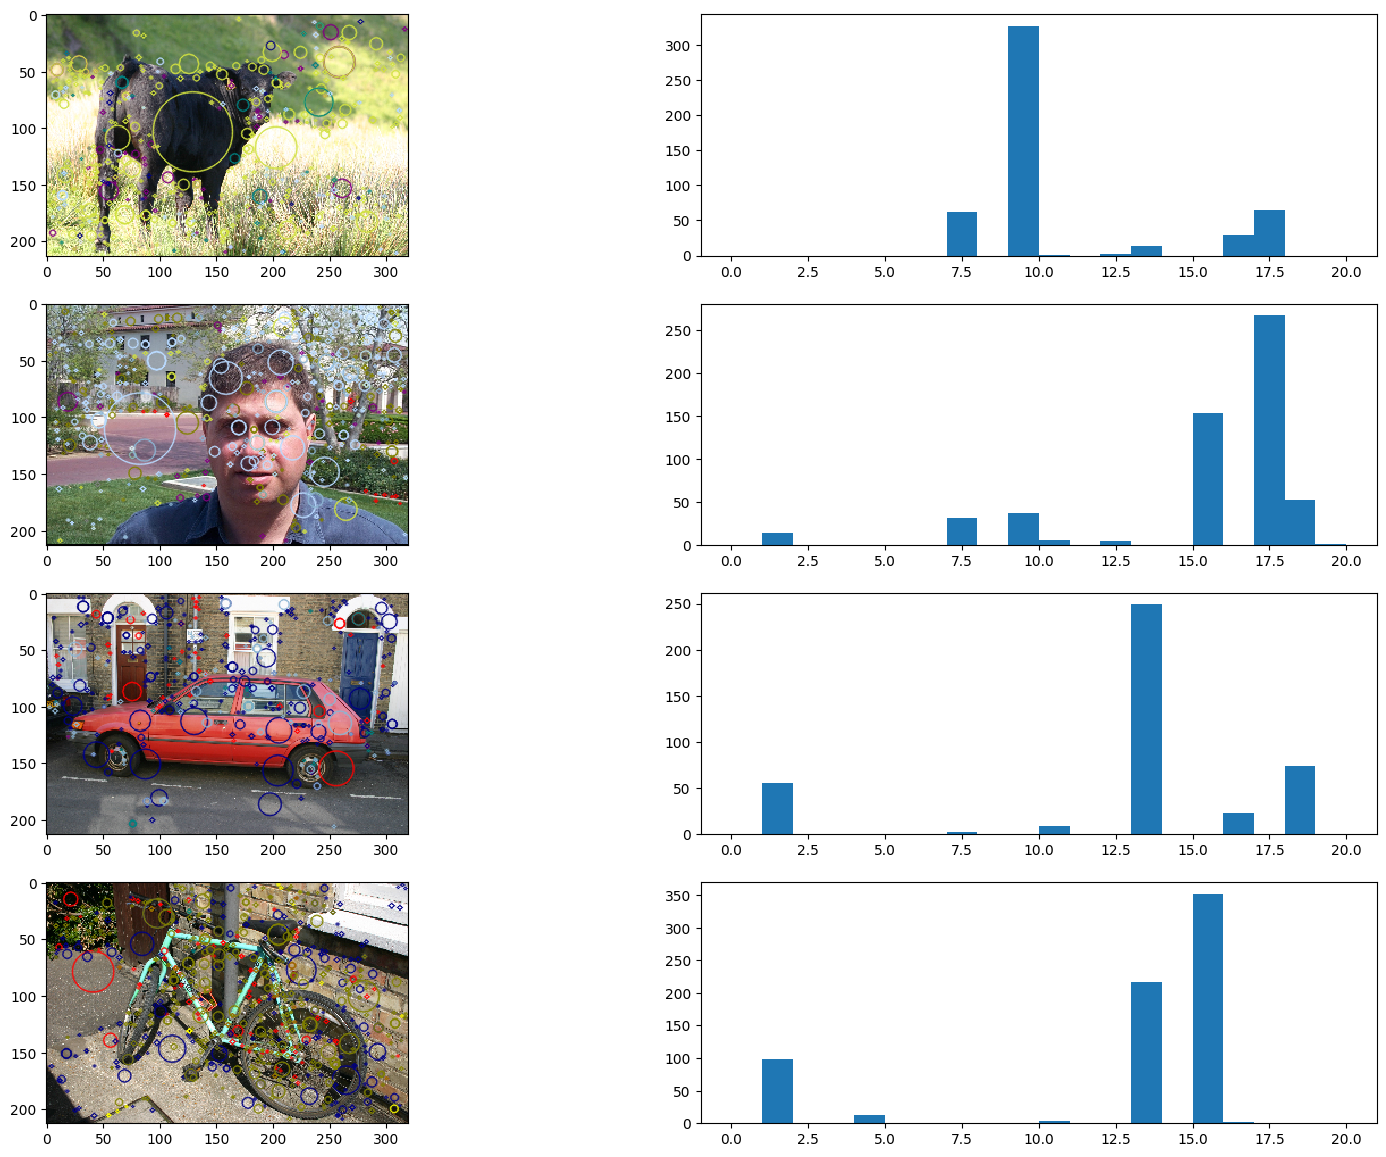

In [ ]:
test_topic_keypoints, test_topic_labels = assign_topics_to_words(test_word_topics, test_keypoints)
word_topics_occurrencies = count_word_topics_occurrencies(test_word_topics, test_results, N_TOPICS)
for topics_occurrencies, topic_keypoints in zip(word_topics_occurrencies, test_keypoints):
  print(f"{len(topic_keypoints)} - Topic occurrencies: {topics_occurrencies}")
for j in range(2):
  plot_bovw_images(
      test_results[4*j:4*(j+1)], test_topic_labels[4*j:4*(j+1)], dir_path, test_images_filenames[4*j:4*(j+1)],
      test_topic_keypoints[4*j:4*(j+1)], N_TOPICS, 4, figsize=(19.2, 14.4), verbose=False,
  )

## Analysis of the results
As we can see in the above results, in most cases the predicted topic for the image corresponds to the most frequently predicted one for SIFT descriptors in that image, such as topic $16$ or $18$. There are cases in which the predicted topic is *almost the only one*, like in the second and third image, hence we may suppose that topic $16$ is strongly related to shapes of grass and trees, or in the image of the house for topic $4$.

However, there are also cases in which the LDA seems to not identify a proper topic for the image, like in the case of the airplane, in which topic $13$ and $18$ share almost an equal part of the image, but the predicted topic is $1$ instead any of them, or similarly in the second image of the cow, where the dominant topic is $9$ but the predicted is $16$, which appears rarely in the image.

Apart from these inaccuracies, we can however say that in most cases the LDA has been capable of coherently associate image and word topics according to the most frequent one, even if several results do not agree with the corresponding training topic distributions.

## Final Considerations
We have shown how the LDA technique may be used for unsupervised Image Understanding using the Bag of Visual Words model. Even if it does not get a complete understanding of the topic of the images as we humans may do, it however captures several common shapes in the images.

Some weak aspects that could be improved are:

1. number of clusters: for simplicity, we have used $500$ words out of a training set of more than $100,000$ descriptors, meaning that we have $200$ "examples" for each word, which are sufficient to delineate meaningful clusters, but one can try to use $100$ or $1000$ clusters to see if this improves accuracy of the model;

2. number of topics: the fact that some topics *never* appear in images and similarly in words suggests that $20$ topics may be more than the maximum number of topics that the LDA can distinguish with $500$ words, hence one can either try to fine-tune the number of topics by, for example, using $10$ topics, or to increment the number of words to see if this allows to have $20$ or more topics that are all represented;

3. values of $\alpha$ and $\eta$: for simplicity, we have used only $1$ for both of them, which is a "classic" value for these hyperparameters, since it generates distributions that are "in the middle" of uniform and "unbalanced" ones. One can try to use smaller values for $\alpha$ or $\eta$ to see if in this way topics tend to better correspond to the categories that we humans have assigned to set of images.